In [4]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
import time
import collections
import keras
import random
from keras.utils import np_utils
from keras.layers import MaxPooling1D, Conv1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LSTM, ELU, Bidirectional, Attention
from keras.layers import Dense, Dropout, Activation, Flatten, CuDNNLSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import pickle
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import keras_tuner

### Method for extracting indexes out of filenames

In [2]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    # Synth lead borttagen. id = 9
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

### Get training data - Gamla sätt

In [11]:
with open("CustomDataFull/traindata10000.pkl", "rb") as f:
    X_train_full = pickle.load(f)

X_train = []
y_train = []

for (key, value) in X_train_full.items():
    X_train.append(value)
    y_train.append(instrument_code(key))

X_train_numpy = np.array(X_train)
y_train_numpy = np.array(y_train)
print(X_train_numpy.shape)


(87500, 126, 13)


### Get validation data - Gamla sättet

In [12]:
with open("CustomData/validdata.pkl", "rb") as f:
    X_valid_full = pickle.load(f)

X_valid = []
y_valid = []

for (key, value) in X_valid_full.items():
    X_valid.append(value)
    y_valid.append(instrument_code(key))

X_valid_numpy = np.array(X_valid)
y_valid_numpy = np.array(y_valid)
print(X_valid_numpy.shape)


(100, 128, 173)


### Get testing data - Gamla sättet

In [3]:
with open("CustomDataFull/testdata2000.pkl", 'rb') as f:
    X_test_full = pickle.load(f)

X_test = []
y_test = []

for(key, value) in X_test_full.items():
    #temporal_value = np.mean(value, axis = 1)
    X_test.append(value)
    y_test.append(instrument_code(key))
y_test_numpy = np.asarray(y_test)
X_test_numpy = np.asarray(X_test)
print(X_test_numpy.shape)


(4096, 126, 13)


### Building the CNN model

In [14]:
def build_model(hp):
    """
    Function that builds a CNN model with optimized hyperparameters including kernel size, dropout rate and learning rate
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), 
                     activation='relu', padding='same', input_shape=(126, 13, 1)))
    model.add(Conv2D(32, kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), 
                     activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Conv2D(64, kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                        activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                        activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Conv2D(128, kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                        activation='relu', padding='same'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=3, directory='hyperparameters', project_name='cnn_hyperparameters')

tuner.search_space_summary()

Search space summary
Default search space size: 3
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [16]:
tuner.search(X_train_numpy, y_train_numpy, epochs=10, batch_size=10, validation_data=(X_valid_numpy, y_valid_numpy), shuffle=True, verbose=2)

Trial 10 Complete [00h 28m 33s]
val_accuracy: 0.7287952899932861

Best val_accuracy So Far: 0.7287952899932861
Total elapsed time: 04h 12m 33s
INFO:tensorflow:Oracle triggered exit


### Implementation of the CNN

In [13]:
input_shape = (126, 13, 1)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 13, 32)       320       
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 6, 32)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 63, 6, 64)         18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 63, 6, 64)         36928     
                                                      

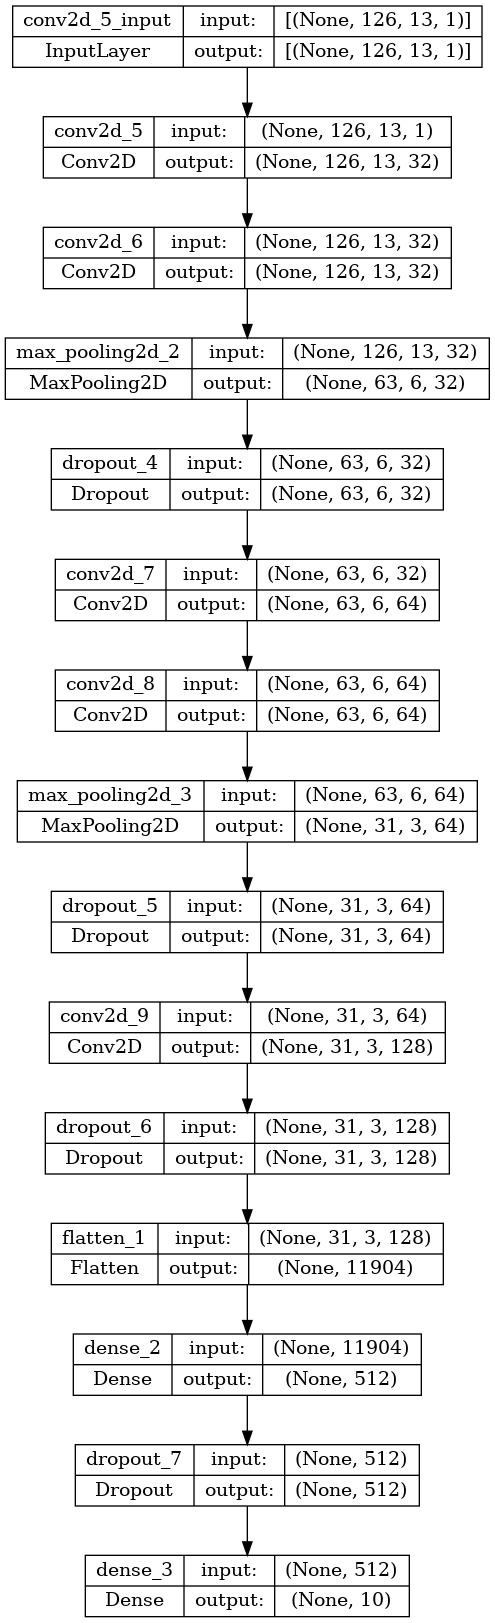

In [14]:
model.summary()

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(x=X_train_numpy, y=y_train_numpy, validation_data=(X_valid_numpy, y_valid_numpy), batch_size=32, epochs=30, shuffle=True, verbose=2)
#history = model.fit(data.batch(32), epochs=30, shuffle=True, verbose=2)

Epoch 1/30


2023-04-26 20:06:49.651529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-26 20:06:50.036739: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d3cf440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-26 20:06:50.036768: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-04-26 20:06:50.249951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-26 20:06:51.868364: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2735/2735 - 27s - loss: 1.7287 - accuracy: 0.3591 - val_loss: 1.5740 - val_accuracy: 0.3990 - 27s/epoch - 10ms/step
Epoch 2/30
2735/2735 - 19s - loss: 1.2224 - accuracy: 0.5522 - val_loss: 1.4182 - val_accuracy: 0.4938 - 19s/epoch - 7ms/step
Epoch 3/30
2735/2735 - 19s - loss: 1.0174 - accuracy: 0.6266 - val_loss: 1.3195 - val_accuracy: 0.5629 - 19s/epoch - 7ms/step
Epoch 4/30
2735/2735 - 19s - loss: 0.8817 - accuracy: 0.6769 - val_loss: 1.3429 - val_accuracy: 0.5990 - 19s/epoch - 7ms/step
Epoch 5/30
2735/2735 - 19s - loss: 0.7829 - accuracy: 0.7140 - val_loss: 1.4006 - val_accuracy: 0.5930 - 19s/epoch - 7ms/step
Epoch 6/30
2735/2735 - 19s - loss: 0.7006 - accuracy: 0.7449 - val_loss: 1.2858 - val_accuracy: 0.6267 - 19s/epoch - 7ms/step
Epoch 7/30
2735/2735 - 20s - loss: 0.6384 - accuracy: 0.7684 - val_loss: 1.3839 - val_accuracy: 0.6501 - 20s/epoch - 7ms/step
Epoch 8/30
2735/2735 - 20s - loss: 0.5832 - accuracy: 0.7868 - val_loss: 1.3815 - val_accuracy: 0.6607 - 20s/epoch - 7ms/step
Ep

# Testing

128/128 [==============================] - 0s 2ms/step
['loss', 'accuracy']
[1.7908635139465332, 0.736572265625]


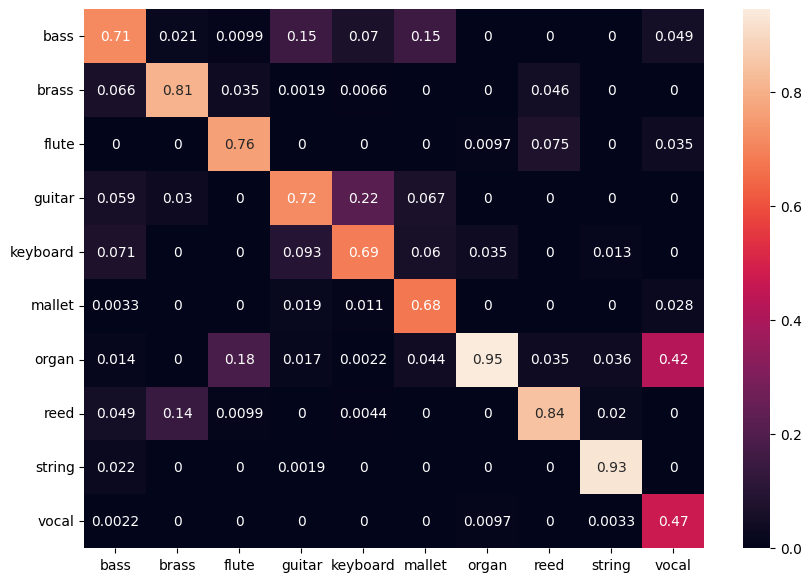

In [17]:
# Score trained model.
scores = model.evaluate(X_test_numpy, y_test_numpy, verbose=1)

y_prediction = model.predict(X_test_numpy)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(y_test_numpy, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                  columns = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

print(model.metrics_names)
print(scores)

### Plot loss and accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


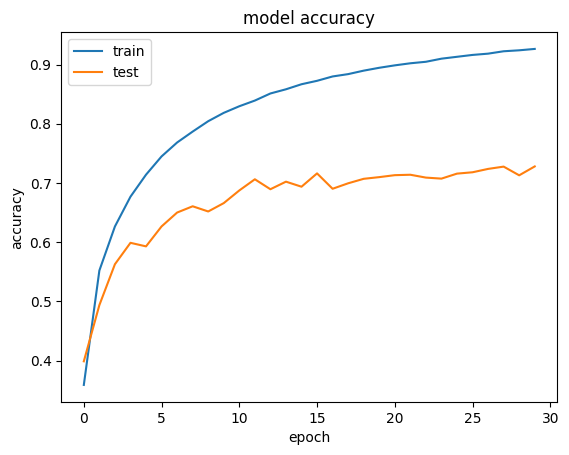

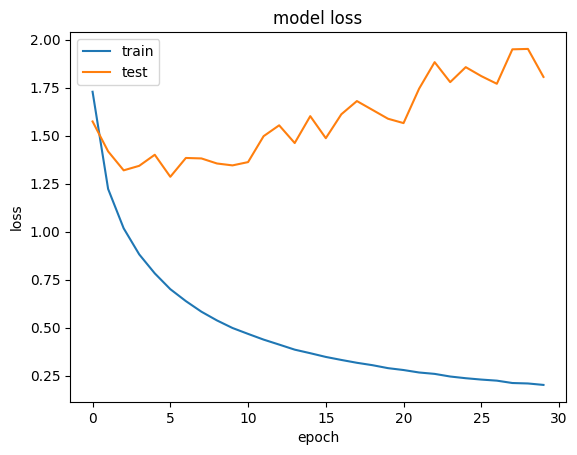

In [18]:

# list all data in history
print(history.history.keys())


# Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model and history

In [20]:
model_name = 'models/conv2d_87500_126_13_30epochs.h5'
history_name = 'models/conv2d_87500_126_13_30epochs-history'

model.save(model_name)
with open(history_name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Loading the model and history

In [5]:
model = tf.keras.models.load_model('models/conv2d_87500_126_13_30epochs.h5')

with open('models/conv2d_87500_126_13_30epochs-history', 'rb') as f:
    history = pickle.load(f)

# Score trained model.
scores = model.evaluate(X_test_numpy, y_test_numpy, verbose=1)

y_prediction = model.predict(X_test_numpy)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(y_test_numpy, y_prediction , normalize='pred')

#print(y_prediction)
#print(y_test_numpy)

print(result.shape)


2023-04-28 11:34:54.589188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 11:34:55.161362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 11:34:55.161590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 11:34:55.185101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

128/128 [==============================] - 0s 2ms/step
(10, 10)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


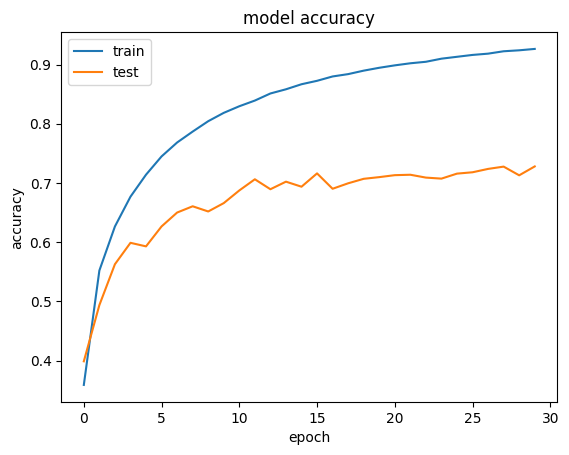

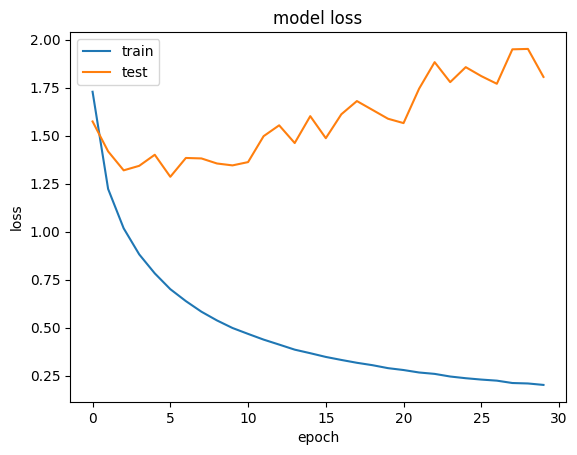

In [8]:
# list all data in history
print(history.keys())


# Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_loss_plots/acc-conv2d_87500_126_13_30epochs.png')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_loss_plots/loss-conv2d_87500_126_13_30epochs.png')
plt.show()


<Axes: >

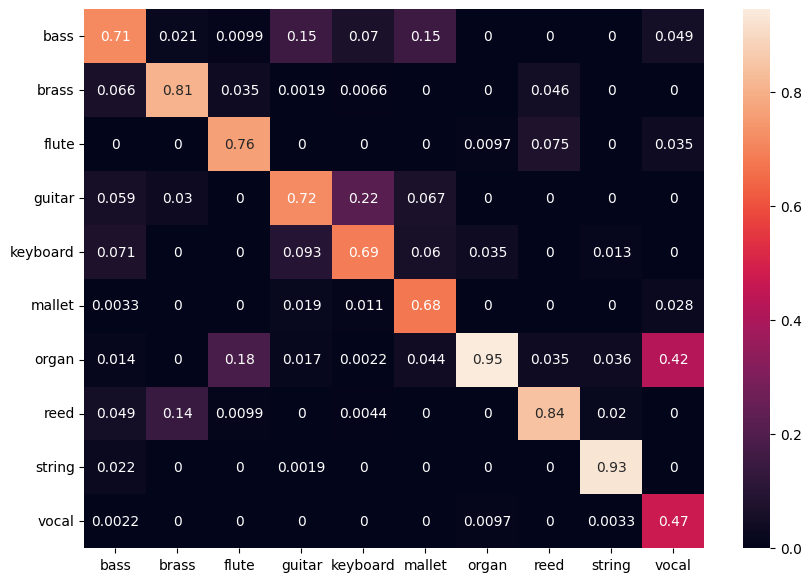

In [24]:


df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                  columns = [i for i in [         "bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### Spara plot av modellen

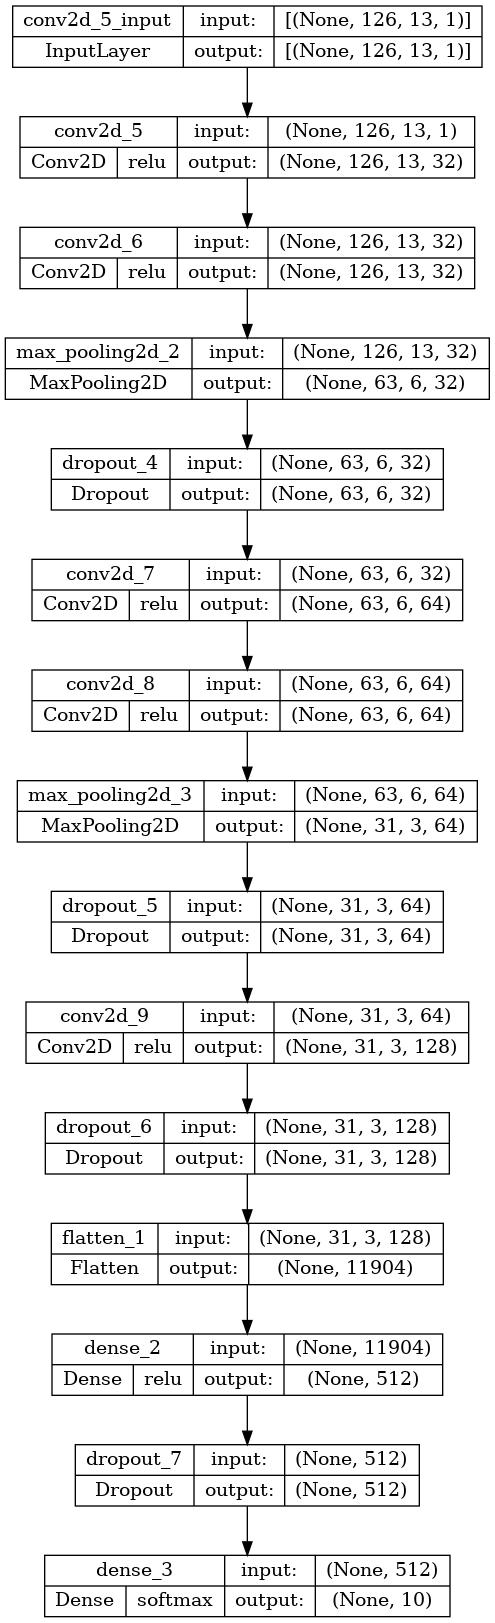

In [6]:
plot_model(model, to_file='model_plots/conv2d_87500_126_13_30epochs-copy.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)